## 0. 필요한 라이브러리 import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

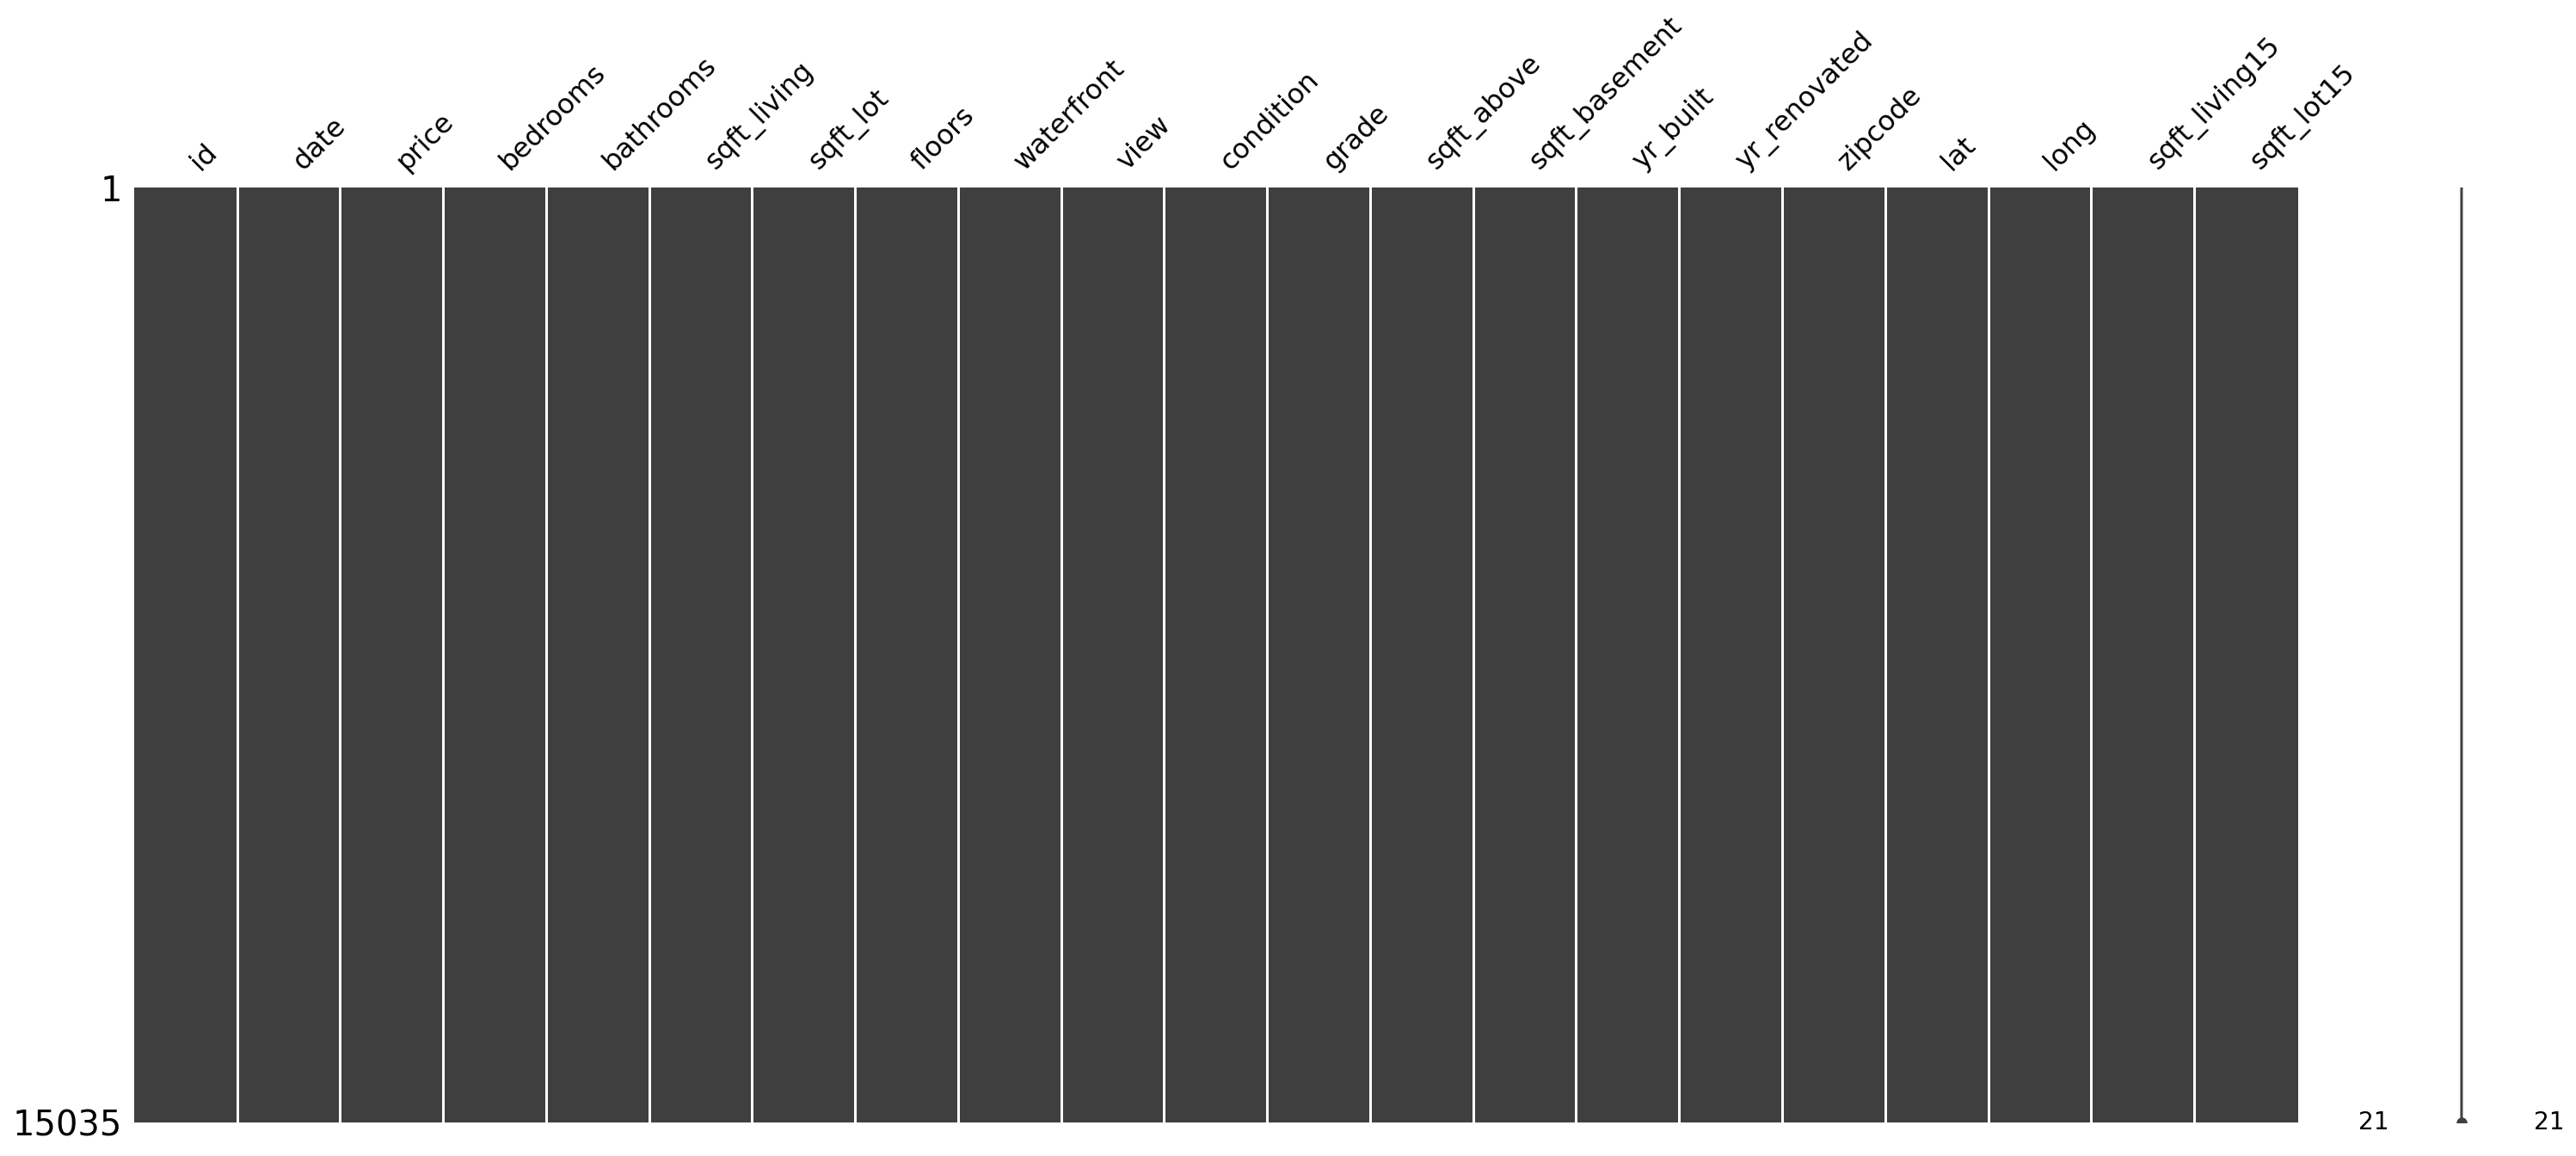

In [4]:
msno.matrix(train)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [5]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 정수형 변수로 만들어 Model이 활용할 수 있도록 합니다.

In [6]:
sub_id = train['id'][len(train):]
del train['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)

In [7]:
train.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  201410  221900.0         3       1.00         1180      5650     1.0   
1  201502  180000.0         2       1.00          770     10000     1.0   
2  201502  510000.0         3       2.00         1680      8080     1.0   
3  201406  257500.0         3       2.25         1715      6819     2.0   
4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

In [8]:
# 타겟 데이터에 해당하는 price 컬럼을 y 변수에 넣어두고, train에서는 삭제
y = train['price']
del train['price']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test data에 대해서도 동일한 작업 수행

In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

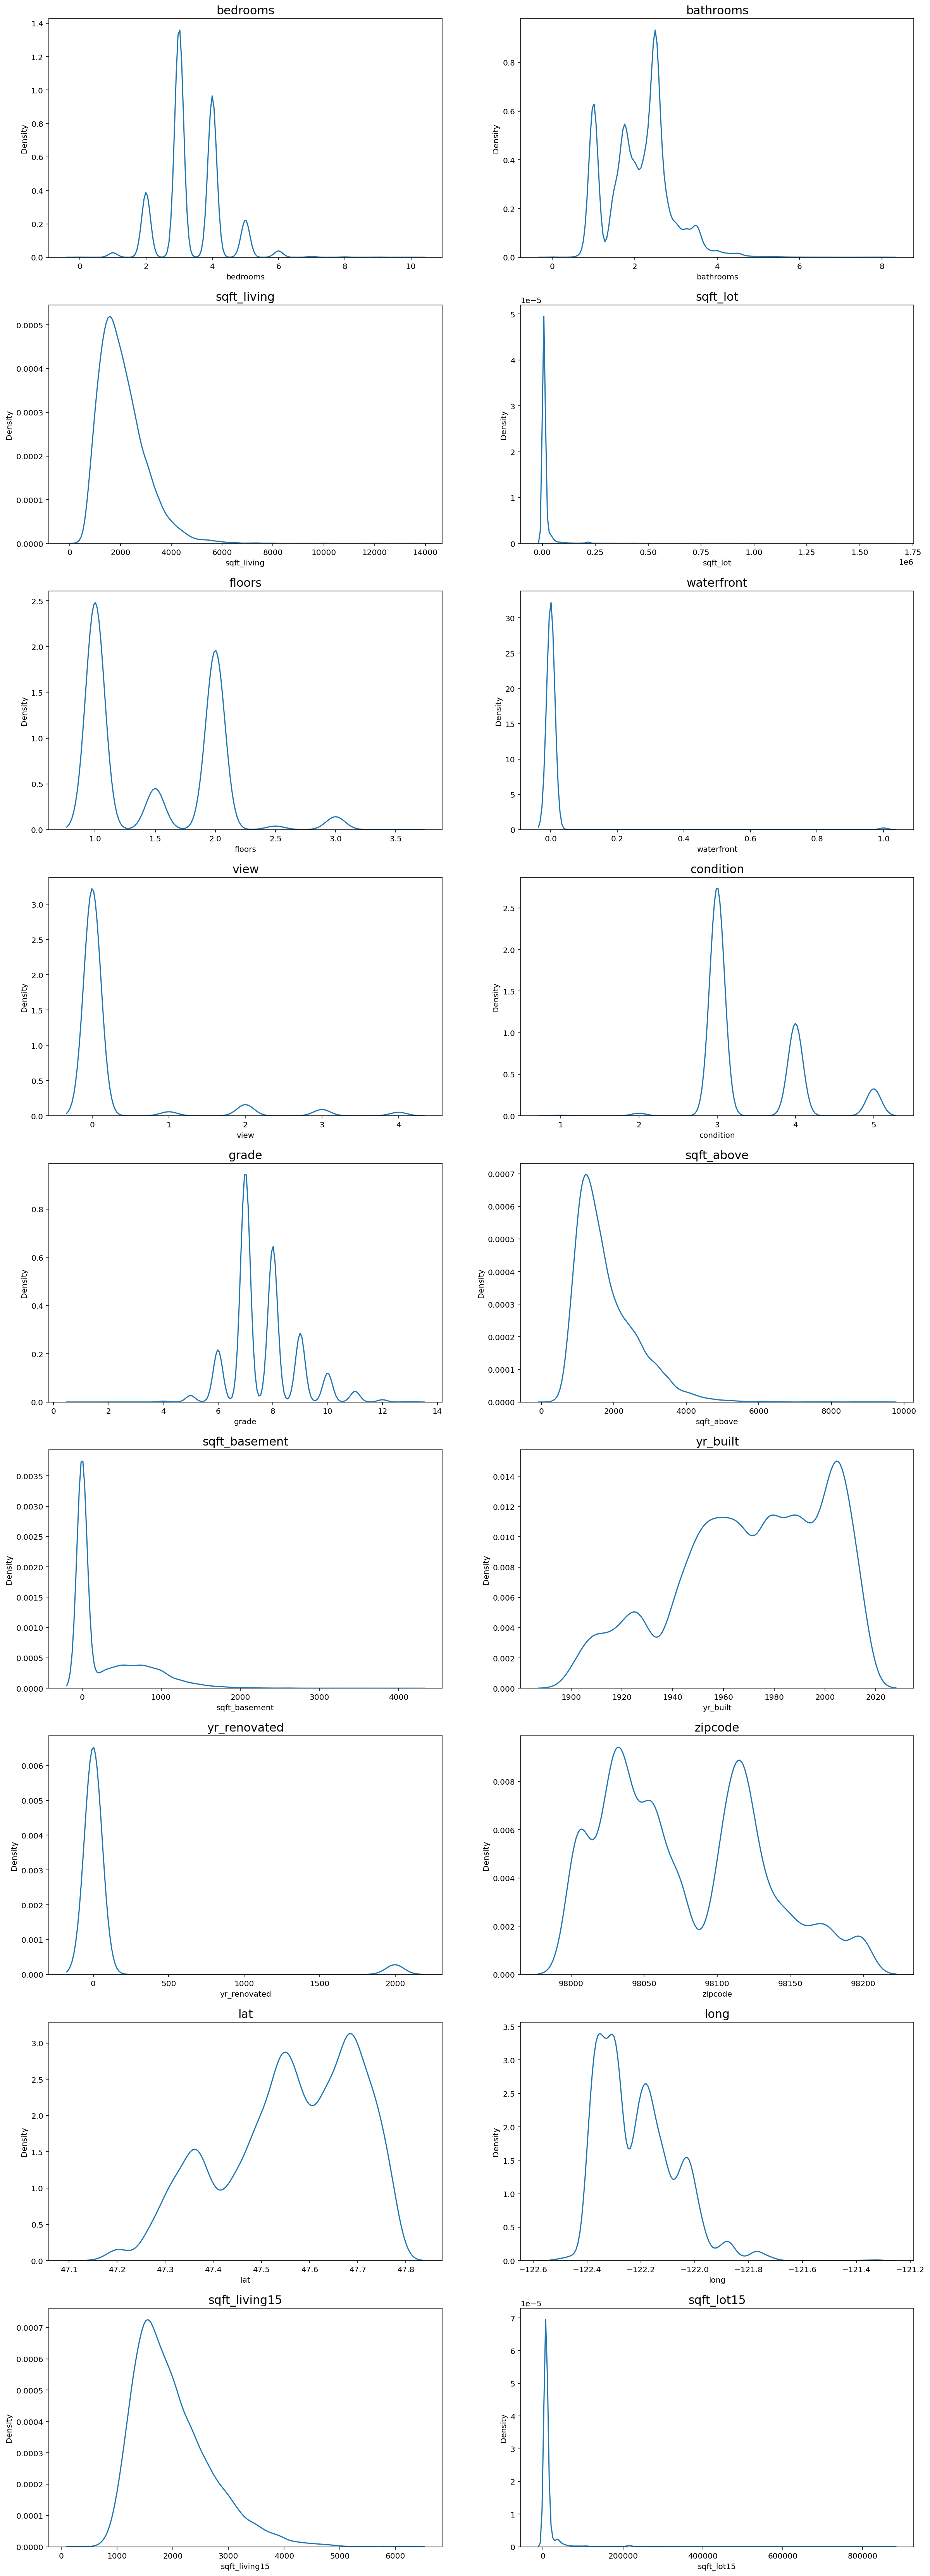

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))  # price, ID column 삭제했으므로 19개 column

# date(거래년월) 변수는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [11]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

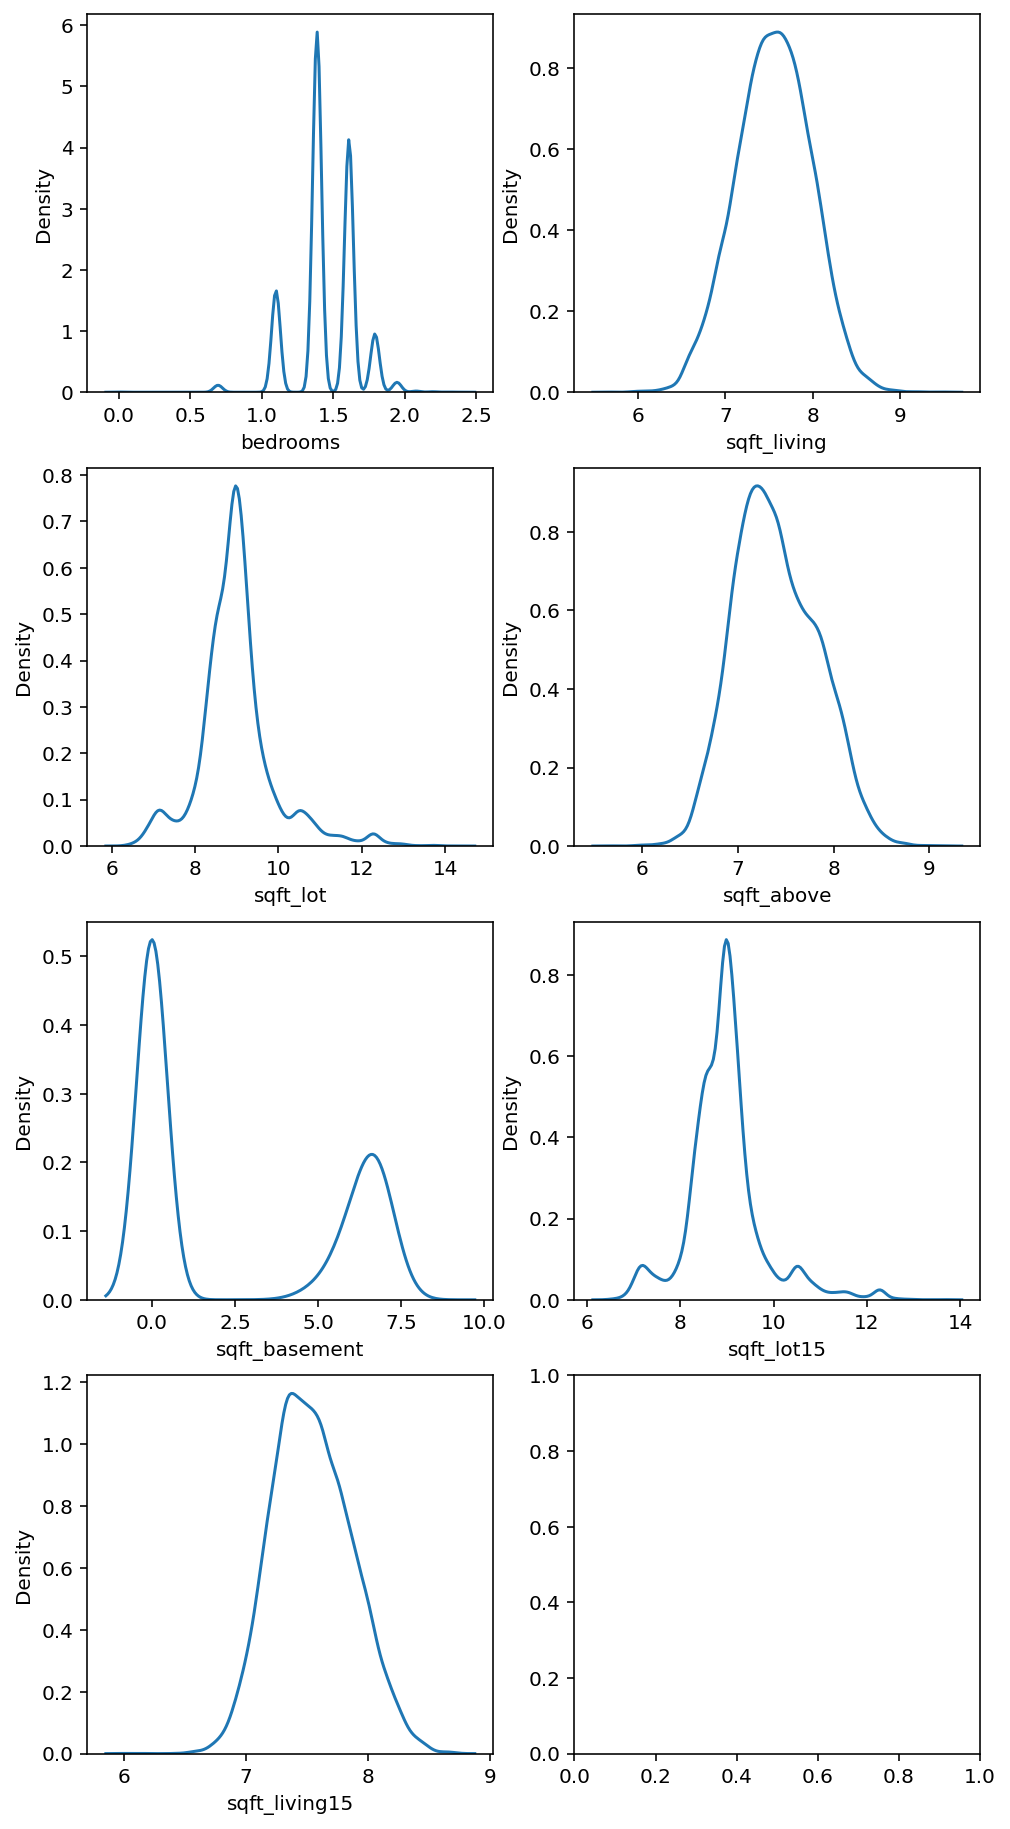

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
#        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1


어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

가격데이타에 대한 분포 확인

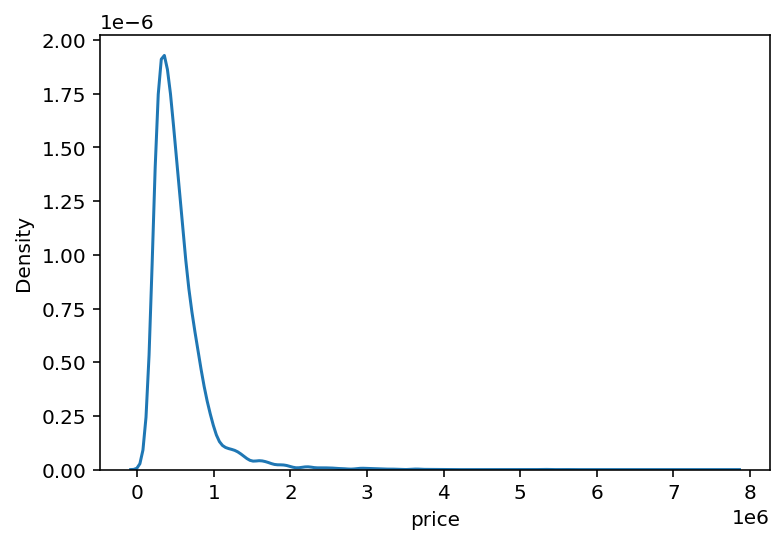

In [13]:
sns.kdeplot(y)
plt.show()

가격데이타도 0~1 사이에 집중되어 있으므로 로그변환하고 분포 확인

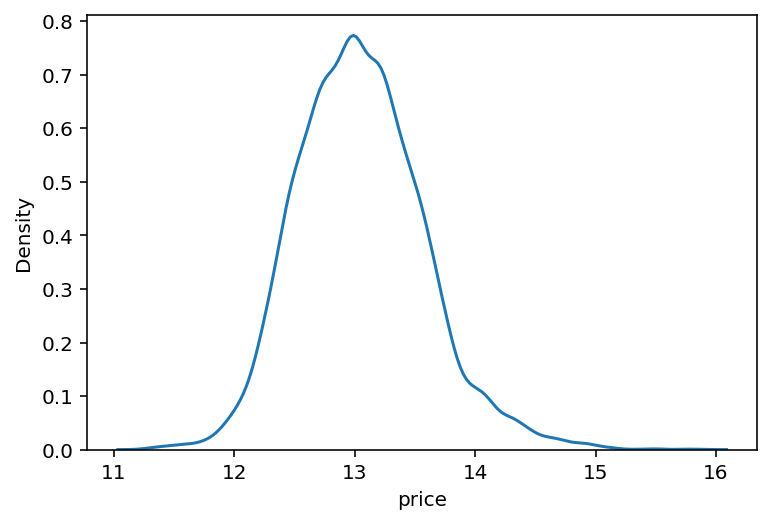

In [14]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [15]:
# RMSE 계산을 위한 라이브러리 import및 함수작성
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 3. 모델링
### Average Blending
아래의 4가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor

In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [17]:
# 각 모델 별로 학습 및 예측을 수행
from sklearn.model_selection import train_test_split

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

RMSE
GradientBoostingRegressor  128370.486911
RandomForestRegressor      125299.591549
LGBMRegressor              111906.268088
XGBRegressor               110319.723794

# 4. 하이퍼 파라미터 튜닝
sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용

•	param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)

•	scoring : 모델의 성능을 평가할 지표

•	cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수

•	verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력)

•	n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [18]:
from sklearn.model_selection import GridSearchCV

# 모델은 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 사용
models = [gboost, xgboost, lightgbm, rdforest]
def my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5):
    
    scores = []
    
    # GridSearchCV 모델로 초기화
    for model in models:
        grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                                  cv=5, verbose=verbose, n_jobs=n_jobs)

        # 모델 fitting
        grid_model.fit(train, y)
        
        # 결과값 저장
        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
        
        print('model:', model)
        print('params:', params)
        print('score:', score)
        
        scores.append(score)
        
    scores = np.array(scores)
    scores = np.mean(scores, axis=0)
    
    print('scores:', scores)
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = scores
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

Try & Error 방식으로 아래 param_grid 요소의 최적값을 찾았음

In [19]:
param_grid = {
    'n_estimators': [365, 370, 375],
    'max_depth': [8, 10, 12],
}
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

gridSearchResult = my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5)
print(gridSearchResult)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
model: GradientBoostingRegressor(random_state=2020)
params: [{'max_depth': 8, 'n_estimators': 365}, {'max_depth': 8, 'n_estimators': 370}, {'max_depth': 8, 'n_estimators': 375}, {'max_depth': 10, 'n_estimators': 365}, {'max_depth': 10, 'n_estimators': 370}, {'max_depth': 10, 'n_estimators': 375}, {'max_depth': 12, 'n_estimators': 365}, {'max_depth': 12, 'n_estimators': 370}, {'max_depth': 12, 'n_estimators': 375}]
score: [-0.02785858 -0.02785134 -0.02786036 -0.02945584 -0.02945563 -0.02945625
 -0.03264815 -0.03264779 -0.03264787]
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

model: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
params: [{'max_depth': 8, 'n_estimators': 365}, {'max_depth': 8, 'n_estimators': 370}, {'max_depth': 8, 'n_estimators': 375}, {'max_depth': 10, 'n_estimators': 365}, {'max_depth': 10, 'n_estimators': 370}, {'max_depth': 10, 'n_estimators': 375}, {'max_depth': 12, 'n_estimators': 365}, {'max_depth': 12, 'n_estimators': 370}, {'max_depth': 12, 'n_estimators': 375}]
scor

가장 좋은 조합은 max_depth=10, n_estimators=370 으로 나타났습니다.

그럼 이 조합으로 학습하고 예측을 수행 (값을 받아와서 학습)

In [20]:
md = int(gridSearchResult.iloc[0]['max_depth'])
ne = int(gridSearchResult.iloc[0]['n_estimators'])

gboost = GradientBoostingRegressor(max_depth=md, n_estimators=ne, random_state=random_state)
xgboost = XGBRegressor(max_depth=md, n_estimators=ne, random_state=random_state)
lightgbm = LGBMRegressor(max_depth=md, n_estimators=ne, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=md, n_estimators=ne, random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
predictions = []

for model in models:
    model.fit(train, y)
    pred = model.predict(test)
    print(pred)
    predictions.append(pred)

predictions = np.array(predictions)
prediction = np.mean(predictions, axis=0)
print(prediction)

# 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌림
prediction = np.expm1(prediction)
prediction

[13.54986147 13.46035378 14.45819519 ... 14.09425969 13.77722342
 13.72952431]
[14.238135  14.112695  14.120069  ... 14.5536785 14.344003  14.444283 ]
[13.83814529 13.86329533 14.39457667 ... 14.31822579 14.08971378
 14.04166585]
[13.33739386 13.34321887 14.40581841 ... 13.84563869 13.76131551
 13.52258388]
[13.74088399 13.69489068 14.34466471 ... 14.20295067 13.99306386
 13.93451414]


array([ 928088.9981987 ,  886369.82397814, 1697494.87013775, ...,
       1473203.7243535 , 1194290.71353628, 1126372.95647485])

## 5. Make Submission

In [21]:
# sample_submission.csv 파일을 가져옴
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [22]:
# 위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌움
submission['price'] = prediction
submission.head()

id         price
0  15035  9.280890e+05
1  15036  8.863698e+05
2  15037  1.697495e+06
3  15038  6.401673e+05
4  15039  7.544828e+05

In [23]:
# 위의 데이터를 csv 파일로 저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'AB', 'HPT')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_AB_RMSLE_HPT.csv
[CV] END ......................max_depth=8, n_estimators=365; total time= 2.4min
[CV] END ......................max_depth=8, n_estimators=370; total time= 2.5min
[CV] END ......................max_depth=8, n_estimators=375; total time= 2.5min
[CV] END .....................max_depth=10, n_estimators=365; total time= 3.0min
[CV] END .....................max_depth=10, n_estimators=370; total time= 3.0min
[CV] END .....................max_depth=10, n_estimators=375; total time= 3.0min
[CV] END .....................max_depth=12, n_estimators=365; total time= 3.6min
[CV] END .....................max_depth=12, n_estimators=370; total time= 3.6min
[CV] END .....................max_depth=12, n_estimators=375; total time= 3.6min
[CV] END ......................max_depth=8, n_estimators=365; total time= 4.2min
[CV] END ......................max_depth=8, n_estimators=370; total time= 4.2min
[CV] END ......................max_depth=

1. 하이퍼 파라미터 튜닝을 했는데 submission 결과는 Baseline 116123에서 655199로 나빠졌다.
여러가지 모델을 사용한 Average값을 도출하지 않고 LightGBM(lgbm)만 사용해서 그런모양....


2. 4가지 모델을 사용한 Average Blending을 적용했음에도 718011로 더 나빠졌다.
4가지 model중 score가 가장 좋은 LGBM만 가지고 tuning을 정밀히 해 봐야겠다.

Note: 뭔가 크게 잘못되었다고 생각됨. 제출기한 임박으로 일단 제출

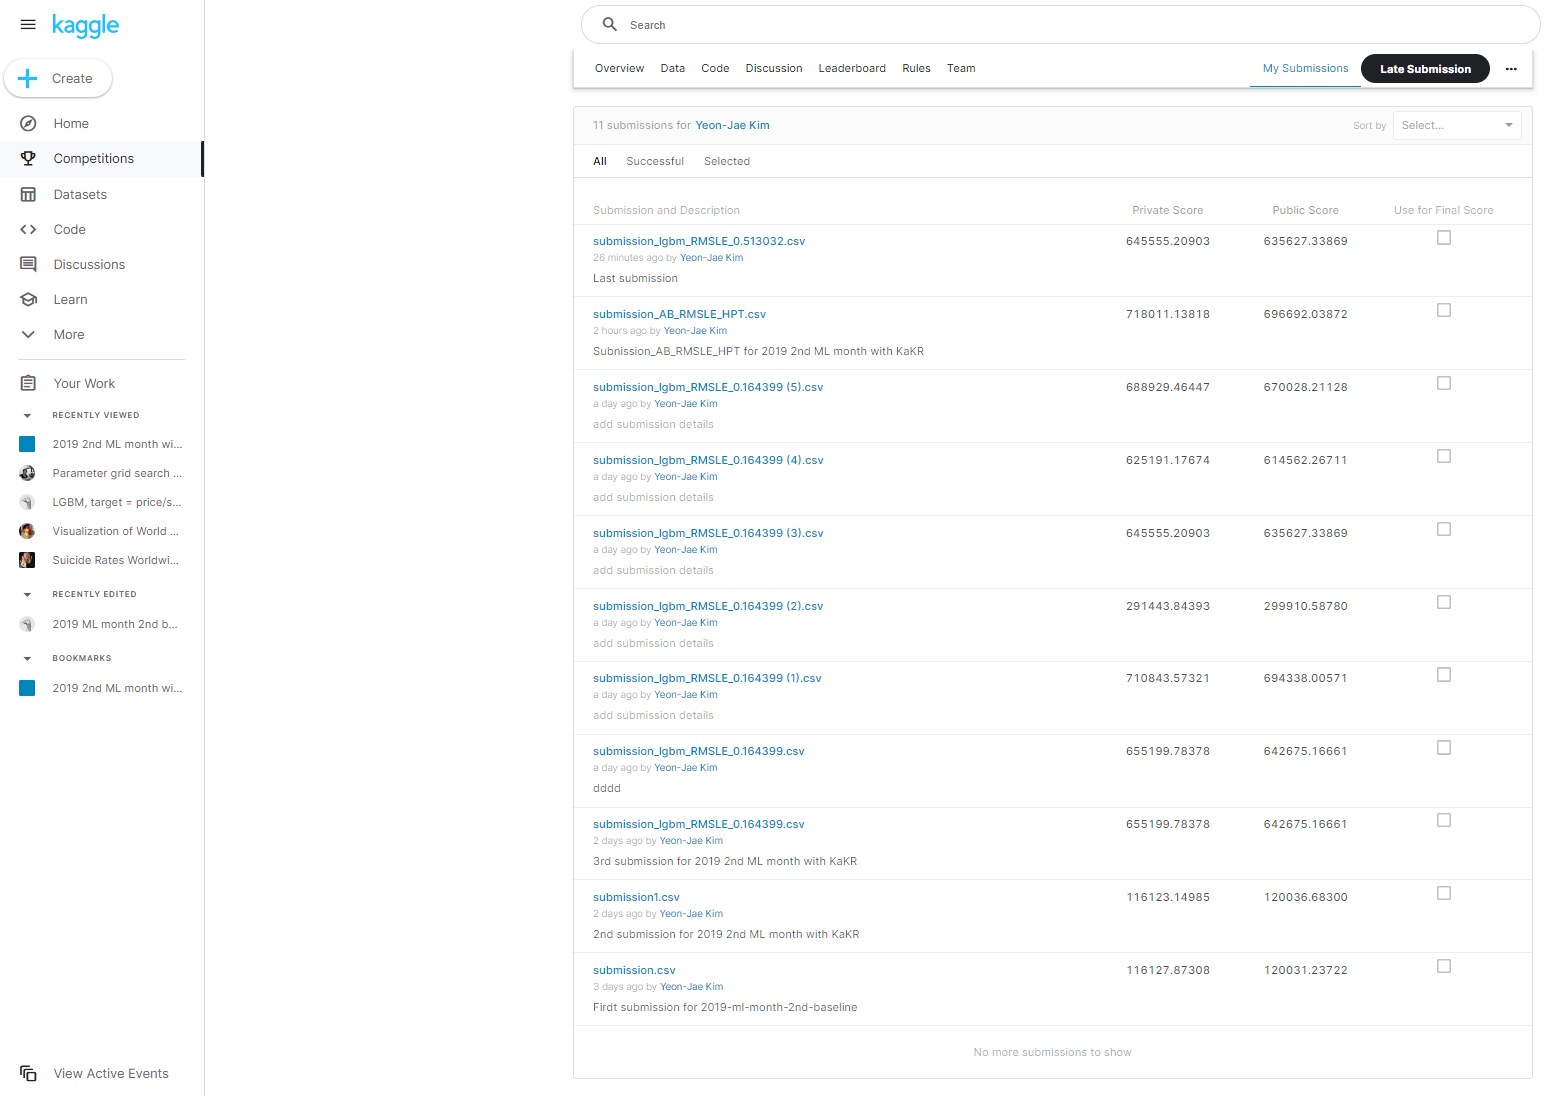